In [ ]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm
import pandas as pd

In [ ]:
#Majority class	| BoW L2 LogReg
#0.36	| 0.37

In [ ]:
train = pd.read_table('train.txt', names = ['num', 'score', 'text'])
test = pd.read_table('test.txt', names = ['num', 'score', 'text'])
dev = pd.read_table('dev.txt', names = ['num', 'score', 'text'])

In [ ]:
train

,num,score,text
0,417,2,Which fairground ride is made of iron? The fer...
1,495,3,Why does a chicken coupe only have two doors? ...
2,378,1,Where do you go to weigh a pie? Somewhere over...
3,670,1,Choose a major you love and you won't have to ...
4,345,4,What animal is best at hitting a baseball? A bat!
...,...,...,...
595,900,1,"Knock, Knock... Who's there? The K.G.B. The K...."
596,245,1,How many catholics does it take to change a li...
597,924,2,What is ISIL's favourite dessert? Terrormisu
598,630,1,In what town lives the mathematician who can o...


In [ ]:
test

,num,score,text
0,994,1,You know what's the problem with Mexican and b...
1,564,2,What did the Buddhist say to the hotdog vendor...
2,93,4,What do you call a sleeping dinosaur? A dino-s...
3,185,3,What is an astronaut's favorite meal? Launch
4,598,2,What's the difference between a bag of chips a...
...,...,...,...
196,782,2,Why did the chicken cross the road? To get to ...
197,821,3,Why doesn't the sun need to go to University? ...
198,867,3,Where do Cows go for parties? The Moovies
199,582,1,Did you hear that H.P. Lovecraft wrote a cookb...


In [ ]:
dev

,num,score,text
0,823,4,Do you know why one side of the the V formatio...
1,840,3,Why don't you want your nose to be 12 inches l...
2,793,1,This summer I'm going to go to the beach and b...
3,859,1,What do you get when you mix two chains and a ...
4,612,1,Why didn't the fisherman go to Florida to fish...
...,...,...,...
195,17,1,I went for a job interview today... The interv...
196,85,3,Why are manhole covers round? Because manholes...
197,72,1,What do you call Protestants who want to save ...
198,689,1,New Internet acronym: RALSHMICOMN Rolling Arou...


In [ ]:
# Copied from https://github.com/dbamman/nlp22/blob/main/AP/OrdinalRegression.ipynb

In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def load_ordinal_data(filename, ordering):
    X = []
    Y = []
    orig_Y=[]
    for ordinal in ordering:
        Y.append([])
        
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[1].lstrip().rstrip()
            text = cols[2]

            X.append(text)
            
            index=ordering.index(label)
            for i in range(len(ordering)):
                if index > i:
                    Y[i].append(1)
                else:
                    Y[i].append(0)
            orig_Y.append(label)
                    
    return X, Y, orig_Y

In [ ]:
class OrdinalClassifier:

    def __init__(self, ordinal_values, feature_method, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY):
        self.ordinal_values=ordinal_values
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_regs = [None]* (len(self.ordinal_values)-1)

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.orig_trainY=orig_trainY
        self.orig_devY=orig_devY
        self.orig_testY=orig_testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    def train(self):
        (D,F) = self.trainX.shape

        
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            best_dev_accuracy=0
            best_model=None
            for C in [0.1, 1, 10, 100]:

                log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
                log_reg.fit(self.trainX, self.trainY[idx])
                development_accuracy = log_reg.score(self.devX, self.devY[idx])
                if development_accuracy > best_dev_accuracy:
                    best_dev_accuracy=development_accuracy
                    best_model=log_reg


            self.log_regs[idx]=best_model
        
    def test(self):
        cor=tot=0
        counts=Counter()
        preds=[None]*(len(self.ordinal_values)-1)
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            preds[idx]=self.log_regs[idx].predict_proba(self.testX)[:,1]
        
        preds=np.array(preds)
            
        for data_point in range(len(preds[0])):
            
    
            ordinal_preds=np.zeros(len(self.ordinal_values))
            for ordinal in range(len(self.ordinal_values)-1):
                if ordinal == 0:
                    ordinal_preds[ordinal]=1-preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal]=preds[ordinal-1][data_point]-preds[ordinal][data_point]

            ordinal_preds[len(self.ordinal_values)-1]=preds[len(preds)-1][data_point]

            prediction=np.argmax(ordinal_preds)
            counts[prediction]+=1
            if prediction == self.ordinal_values.index(self.orig_testY[data_point]):
                cor+=1
            tot+=1

        return cor/tot

In [ ]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats

In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
def run(trainingFile, devFile, testFile, ordinal_values):


    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)
    
    simple_classifier = OrdinalClassifier(ordinal_values, binary_bow_featurize, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    lower, upper=confidence_intervals(accuracy, len(devY[0]), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

In [ ]:
trainingFile = "train.txt" 
devFile = "dev.txt"
testFile = "test.txt"
    
# ordinal values must be in order *as strings* from smallest to largest, e.g.:
# ordinal_values=["G", "PG", "PG-13", "R"]

ordinal_values=["1", "2", '3', '4']

run(trainingFile, devFile, testFile, ordinal_values)

Test accuracy for best dev model: 0.363, 95% CIs: [0.297 0.430]



In [ ]:
# Copied from https://github.com/dbamman/nlp22/blob/main/AP/BERT.ipynb
# Before executing this notebook on Colab, make sure you're running on cuda (Runtime > Change runtime type > GPU) to make use of GPU speedups.

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 31.7 MB/s 
     |████████████████████████████████| 6.6 MB 64.5 MB/s 
     |████████████████████████████████| 895 kB 66.8 MB/s 
     |████████████████████████████████| 77 kB 9.5 MB/s 
     |████████████████████████████████| 596 kB 68.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertModel, BertTokenizer
import nltk
import torch
import torch.nn as nn
import numpy as np
import random
from scipy.stats import norm
import math

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


In [ ]:
def read_labels(filename):
    labels={}
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[1]
            if label not in labels:
                labels[label]=len(labels)
    return labels

In [ ]:
def read_data(filename, labels, max_data_points=1000):
  
    data = []
    data_labels = []
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[1]
            text = cols[2]
            
            data.append(text)
            data_labels.append(labels[label])
            

    # shuffle the data
    tmp = list(zip(data, data_labels))
    random.shuffle(tmp)
    data, data_labels = zip(*tmp)
    
    if max_data_points is None:
        return data, data_labels
    
    return data[:max_data_points], data_labels[:max_data_points]

In [ ]:
labels=read_labels("train.txt")

In [ ]:
train_x, train_y=read_data("train.txt", labels, max_data_points=None)
dev_x, dev_y=read_data("dev.txt", labels, max_data_points=None)
test_x, test_y=read_data("test.txt", labels, max_data_points=None)


In [ ]:
def evaluate(model, x, y):
    model.eval()
    corr = 0.
    total = 0.
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                if prediction == y[idx]:
                    corr += 1.
                total+=1                          
    return corr/total, total

In [ ]:
class BERTClassifier(nn.Module):

    def __init__(self, bert_model_name, params):
        super().__init__()
        self.log_reg = None
        self.model_name=bert_model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"], do_basic_tokenize=False)
        self.bert = BertModel.from_pretrained(self.model_name)
        
        self.num_labels = params["label_length"]

        self.fc = nn.Linear(params["embedding_size"], self.num_labels)

    def get_batches(self, all_x, all_y, batch_size=32, max_toks=510):
            
        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer 
      (and limited to a maximum number of WordPiece tokens """

        batches_x=[]
        batches_y=[]
        
        for i in range(0, len(all_x), batch_size):

            current_batch=[]

            x=all_x[i:i+batch_size]

            batch_x = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            batch_y=all_y[i:i+batch_size]

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_y).to(device))
            
        return batches_x, batches_y
  

    def forward(self, batch_x): 
    
        bert_output = self.bert(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         token_type_ids=batch_x["token_type_ids"],
                         output_hidden_states=True)

      # We're going to represent an entire document just by its [CLS] embedding (at position 0)
      # And use the *last* layer output (layer -1)
      # as a result of this choice, this embedding will be optimized for this purpose during the training process.
      
        bert_hidden_states = bert_output['hidden_states']

        out = bert_hidden_states[-1][:,0,:]

        out = self.fc(out)

        return out.squeeze()

In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
def train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=768, doLowerCase=None):

    bert_model = BERTClassifier(bert_model_name, params={"label_length": len(labels), "doLowerCase":doLowerCase, "embedding_size":embedding_size})
    bert_model.to(device)

    batch_x, batch_y = bert_model.get_batches(train_x, train_y)
    dev_batch_x, dev_batch_y = bert_model.get_batches(dev_x, dev_y)

    optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-5)
    cross_entropy=nn.CrossEntropyLoss()

    num_epochs=30
    best_dev_acc = 0.
    patience=5

    best_epoch=0

    for epoch in range(num_epochs):
        bert_model.train()

        # Train
        for x, y in zip(batch_x, batch_y):
            y_pred = bert_model.forward(x)
            loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate
        dev_accuracy, _=evaluate(bert_model, dev_batch_x, dev_batch_y)
        if epoch % 1 == 0:
            print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
            if dev_accuracy > best_dev_acc:
                torch.save(bert_model.state_dict(), model_filename)
                best_dev_acc = dev_accuracy
                best_epoch=epoch
        if epoch - best_epoch > patience:
            print("No improvement in dev accuracy over %s epochs; stopping training" % patience)
            break

    bert_model.load_state_dict(torch.load(model_filename))
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
    return bert_model

In [ ]:
# small BERT -- can run on laptop
# bert_model_name="google/bert_uncased_L-2_H-128_A-2"
# model_filename="mybert.model"
# embedding_size=128
# doLowerCase=True

# bert-base -- slow on laptop; better on Colab
bert_model_name="bert-base-cased"
model_filename="mybert.model"
embedding_size=768
doLowerCase=False

model=train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=embedding_size, doLowerCase=doLowerCase)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 0, dev accuracy: 0.395
Epoch 1, dev accuracy: 0.405
Epoch 2, dev accuracy: 0.410
Epoch 3, dev accuracy: 0.410
Epoch 4, dev accuracy: 0.390
Epoch 5, dev accuracy: 0.390
Epoch 6, dev accuracy: 0.410
Epoch 7, dev accuracy: 0.365
Epoch 8, dev accuracy: 0.330
No improvement in dev accuracy over 5 epochs; stopping training

Best Performing Model achieves dev accuracy of : 0.410


In [ ]:
test_batch_x, test_batch_y = model.get_batches(test_x, test_y)
accuracy, test_n=evaluate(model, test_batch_x, test_batch_y)

lower, upper=confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.403, 95% CIs: [0.335 0.471]



# **Simple Classifier**


In [ ]:
# From https://github.com/dbamman/nlp22/blob/main/AP/LogReg.ipynb
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm

In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[1].lstrip().rstrip()
            text = cols[2]

            X.append(text)
            Y.append(label)

    return X, Y

In [ ]:
def load_data2(filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

In [ ]:
class Classifier:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        #added by Justin
        self.devOrig = load_data2('dev.txt')
        self.trainOrig = load_data2('train.txt')

        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

#             print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model
        

    def test(self):
        return self.log_reg.score(self.testX, self.testY)
        

    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()


In [ ]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats

In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
def run(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)
    
    simple_classifier = Classifier(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()
    
    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights()

In [ ]:
gid=0
trainingFile = "train.txt"
devFile = "dev.txt"
testFile = "test.txt"
    
run(trainingFile, devFile, testFile)

Test accuracy for best dev model: 0.363, 95% CIs: [0.297 0.430]

1	0.387	:
1	0.350	one
1	0.292	know
1	0.261	is
1	0.260	'd
1	0.249	top
1	0.243	.
1	0.242	and
1	0.233	my
1	0.231	,

2	0.316	was
2	0.314	get
2	0.267	's
2	0.256	?
2	0.245	what
2	0.229	love
2	0.217	to
2	0.214	call
2	0.206	with
2	0.191	pair

3	0.364	n't
3	0.268	go
3	0.254	can
3	0.247	so
3	0.201	did
3	0.194	do
3	0.185	catch
3	0.182	bread
3	0.179	never
3	0.178	today

4	0.245	around
4	0.240	just
4	0.220	why
4	0.215	really
4	0.215	...
4	0.200	when
4	0.190	myself
4	0.189	bad
4	0.187	dont
4	0.182	how



# **Confusion Matrix**

In [ ]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


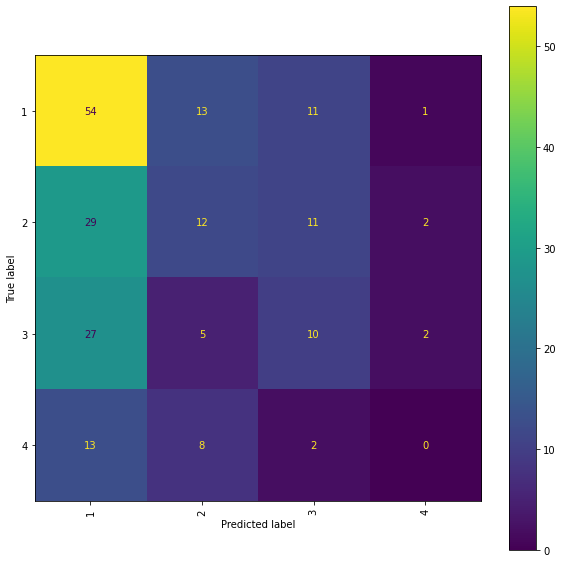

In [ ]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(simple_classifier)

In [ ]:
#Taken from HW2 
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [ ]:
analyze(simple_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,736,0.745464,2,1,My first joke here and an original! Did you hear about the two lawyers who set up shop under the old oak tree? I heard it was a pretty shady business.\n
1,111,0.707241,2,1,"Says she: ""Say something soft and sweet"" Says he: ""Marshmallow.""\n"
2,228,0.628451,3,1,Why do good farmers only excel when they are actually farming? (X-post from /r/jokes) Because they are out standing in their field.\n
3,463,0.619568,2,1,Did you hear about the two monocles at the party? They made spectacles out of themselves.\n
4,297,0.610259,3,1,"If the house is in the kitchen, and Diana's in the kitchen, what's in Diana? A state (Indiana)\n"
5,747,0.601180,2,1,"What is green, sings and can be found in the fridge? Elvis Parsley\n"
6,691,0.598544,2,1,"More retailers should adopt the ""Leave A Penny / Take A Penny"" system. It is literally, common cents.\n"
7,302,0.571459,4,1,"What's so great about living in Switzerland? Well, the flag is a big plus.\n"
8,301,0.559395,4,1,"I got hit hard in the head with a can of 7up today... I'm alright though, it was a soft drink.\n"
9,273,0.556842,4,1,What did the mama pig give her baby pig for its rash? ***OINKMENT!*** &gt; (This exchange that I found on /r/tumblr makes this joke even funnier to me: &gt; http://i.imgur.com/EzT0Bkd.jpg)\n


**For part b.), use the model you've trained on your data to tell us something about the phenomenon you've annotated. **

**Potential ideas for this could include:**

*   Does your model learn features of the phenomenon that you didn't consider in your guidelines that might cause you to rethink the category boundaries? (See Long and So 2016 (Links to an external site.) for an example.)
*   What labels are often mistaken for each other? (e.g., using a confusion matrix (Links to an external site.))
What features are learned to most define the classes?  (E.g., see table 2 in Zhou and Jurgens 2020 (Links to an external site.)).
*   What kind of systematic mistakes does your model make? This could involve reading through test predictions and manually categorizing mistakes that are made (see Manning 2011 (Links to an external site.) section 3 for an example).
*   Are there any biases your model makes? (E.g., by performing worse on different dialects or registers of the language -- see Blodgett et al. 2016 (Links to an external site.) for an example.)
*   Think about the level of balance in your dataset: Is one label extremely prevalent? How could this impact the model you developed? Is your dataset a good candidate for strategies like oversampling (Links to an external site.) or changing class weights (Links to an external site.)? 

Clearly, we can see that the model is predicting a lot of 1's (in fact it predicts no correct 4's).

There are a few things that contribute to this. The presence of punctuation has quite a bit of say in the classes, and I don't think the number of "!" or "?" should have much of an effect on the meaning of the jokes. For example the punchline "a bucaneer" should be the same as "a bucaneer!!!"

Additionally, "a bucaneer!!!" should be the same as "A BUCANEEER!!!!." Perhaps then, something to take into account next time would be to lowercase and remove all punctuation from each joke, to eliminate the dependency upon punctuation that the model forms. However, it may be argued that punctuation or capitalization may have a bit of a say in the articulation and perception of a joke (solely on Reddit (where these jokes come from) or in text form) and therefore its rating as a dad joke. In that case, the removal of punctuation and lowercasing all of the text would remove something prevalent. For future projects one or a few of the following notes/stragies should be helpful:

1.   Specific guidelines should be put in place to help annotators be cognisant of any potential bias in labeling jokes in the presence of capitalization and punctuation.
2.   Punctuation should be entirely removed.
3.   Punctuation shoud be reduced to only one character (Ex. !!! -> !, ! -> !).
4.   Capitalization should be entirely removed.



///

The model has a bias towards categorizing every single joke to be a "1" (not a dad joke). This may be caused by some systematic errors as mentioned above, where punctuation may place a factor or the overall grammatical structure of these sentences. 

The model never categorized any jokes with the rating "4" correctly. In fact, it rarely gave "4"'s in general. It seems to be very giving when it comes to the label "1", but all other labels are almost infrequent. This could be that the model requires a larger dataset to continue growing and increase the accuracy. However, with the given dataset, it is unable to identify the necessary traits to correctly categorize dad jokes by varying degrees.

The model was having a hard time distinguishing dad joke's in varying degrees. A great alternative approach to improve this model would be to entirely change the labeling scale to binary. By changing it to a binary labeling system, there is only right or wrong. This way, the model will have less areas of misunderstanding its task. This could accelerate the model to realize a pattern. Having too many labels to choose from may obstruct the model's understanding of the real purpose of the model, to distinguish dad jokes. The model itself would also have more information in distinguishing what exactly does not fall into a dad joke.

On another note, given that the dataset was sourced from reddit. Some of the jokes within the dataset do not particularly pertain as a joke in the eyes of many. Thus, this may have contributed to what the model was learning as joke versus dad joke. Some are structured in a way where it is typical commentary instead of an actual joke. 

A joke can be presented in many forms such as a narrative, an observation, or even a thought with a set-up. Typically, the key part of jokes is the punchline, the last part of a joke that causes laughter. Dad jokes are a joke type that contains a set-up, but sometimes lacks a punchline. Dad joke focuses on being unfunny that it is funny to some due to its anti-humor (where no punchline is present and it focuses on the irony and sarcasm). 

Another distinguishing characteristic of dad joke's is the shortness of its presentation. The model seems to be unable to capture this characteristic through its training. 



